In [7]:
import time
import copy
import numpy as np
from skimage.filters import gaussian
import cv2

import matplotlib.pyplot as plt
import pylab as pl

%matplotlib inline
%pylab inline
pylab.rcParams['figure.figsize'] = (15, 10)

from tifffile import imread, imsave
import cPickle as pickle

%reload_ext autoreload
%autoreload 2

from netsurface2d import NetSurf2d
from netsurface2dt import NetSurf2dt
from data3d import Data3d

from shapely.geometry import Point
from shapely.geometry.polygon import Polygon

Populating the interactive namespace from numpy and matplotlib


/home/hp/.local/lib/python2.7/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['copy', 'imread', 'imsave', 'Polygon', 'stack']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [24]:
# filename = '/Users/jug/Repositories/GIT/BobSeg/TestLapseData2d_151119-nmy2GFP-tagRfpPH-wt-04_w1LMM_488+488_LP_myTestCrop_bgrem.tif'
#filename = '/Users/jug/Dropbox/ProjectGoldstein/4MyosinMembraneWholeEmbryo.tif'
#filename = '/Users/jug/Repositories/GIT/BobSeg/data/MAX_LP320-06-08_Concat-51-100.tif'
#filename = '/home/hp/git/BobSeg/data/4MyosinMembraneWholeEmbryo.tif'
filename = '/home/hp/git/BobSeg/data/MAX_LP320-06-08_Concat-1-50.tif'


stack = imread(filename)

segchannel = stack[:,0,:,:]
flowchannel = stack[:,1,:,:]
sigma = [0.,2.,2.]
segchannel_smooth = gaussian(segchannel,sigma)

In [60]:
t=10

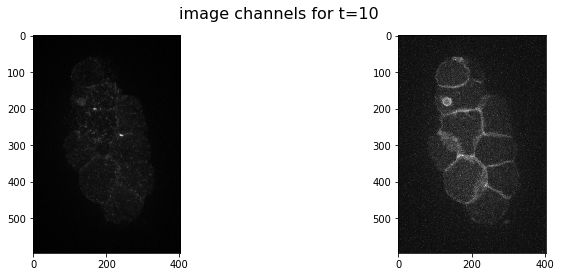

In [61]:
pylab.rcParams['figure.figsize'] = (12, 4)
fig = plt.figure()
fig.suptitle('image channels for t=%d'%t, fontsize=16)
ax = fig.add_subplot(121)
ax.imshow(segchannel[t], plt.get_cmap('gray'))
ax = fig.add_subplot(122)
ax.imshow(flowchannel[t], plt.get_cmap('gray'))

In [62]:
def compute_flow( flowchannel ):
    flows = [None] * len(flowchannel)
    prvs = flowchannel[0]
    for f in range(flowchannel.shape[0]):
        nxt = flowchannel[f]
        flow = cv2.calcOpticalFlowFarneback(prev=prvs,
                                            next=nxt,
                                            pyr_scale=0.5,
                                            levels=3,
                                            winsize=5,
                                            iterations=15,
                                            poly_n=5,
                                            poly_sigma=1.5,
                                            flags=1)
        flows[f] = flow
        prvs = nxt
        print '.',
    print ' ...done!'
    return flows

In [63]:
flows = compute_flow( flowchannel );

. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .  ...done!


In [64]:
shape(flows)

(50, 595, 403, 2)

In [65]:
flow_x = np.moveaxis(np.swapaxes(flows,0,3)[0],-1,0)
flow_y = np.moveaxis(np.swapaxes(flows,0,3)[1],-1,0)

In [66]:
shape(flow_x)

(50, 595, 403)

In [67]:
avg_flow_x = np.average(flow_x[30:], axis=0)
avg_flow_y = np.average(flow_y[30:], axis=0)

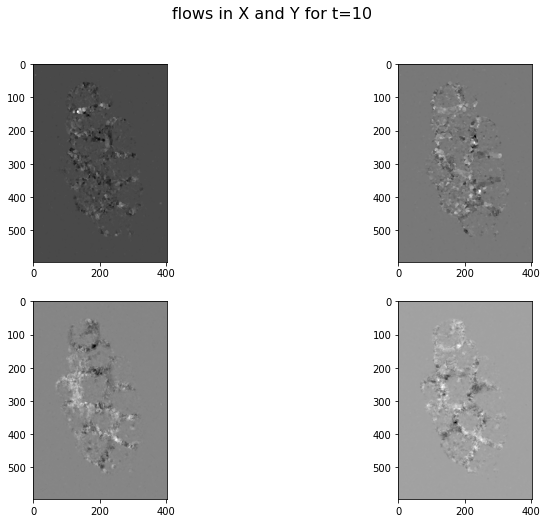

In [68]:
pylab.rcParams['figure.figsize'] = (12, 8)
fig = plt.figure()
fig.suptitle('flows in X and Y for t=%d'%t, fontsize=16)
ax = fig.add_subplot(221)
ax.imshow(flow_x[t], plt.get_cmap('gray'))
ax = fig.add_subplot(222)
ax.imshow(flow_y[t], plt.get_cmap('gray'))
ax = fig.add_subplot(223)
ax.imshow(avg_flow_x, plt.get_cmap('gray'))
ax = fig.add_subplot(224)
ax.imshow(avg_flow_y, plt.get_cmap('gray'))

In [69]:
y,x = np.mgrid[0:shape(segchannel)[1]:1, 0:shape(segchannel)[2]:1]

In [21]:
y

array([[  0,   0,   0, ...,   0,   0,   0],
       [  1,   1,   1, ...,   1,   1,   1],
       [  2,   2,   2, ...,   2,   2,   2],
       ..., 
       [592, 592, 592, ..., 592, 592, 592],
       [593, 593, 593, ..., 593, 593, 593],
       [594, 594, 594, ..., 594, 594, 594]])

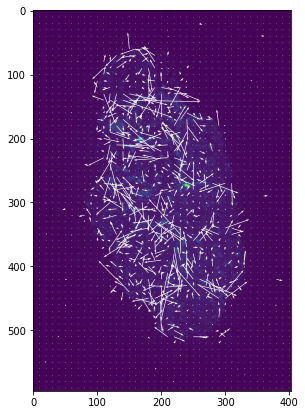

In [72]:
pylab.rcParams['figure.figsize'] = (12, 7)
fig = plt.figure()
fig, ax = plt.subplots()

ax.imshow(segchannel[t])#, plt.get_cmap('gray'))
skip = (slice(None, None, 10), slice(None, None, 10))

ax.quiver(x[skip],y[skip],flow_x[t][skip],-flow_y[t][skip], color='w')

In [71]:
a= [(125, 466),
(127, 463),
(127, 464),
(128, 462),
(128, 463),
(135, 457),
(149, 392),
(159, 468),
(168, 465),
(180, 322),
(181, 321),
(181, 322),
(209, 456),
(241, 230),
(280, 231),
(281, 229),
(281, 230),
(281, 231)]


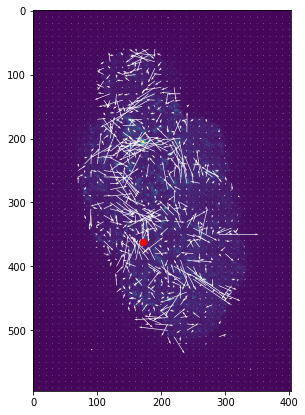

In [59]:
pylab.rcParams['figure.figsize'] = (12, 7)
fig = plt.figure()
fig, ax = plt.subplots()

ax.imshow(segchannel[t])#, plt.get_cmap('gray'))
skip = (slice(None, None, 10), slice(None, None, 10))

ax.quiver(x[skip],y[skip],avg_flow_x[skip],-avg_flow_y[skip], color='w')
ax.scatter(172, 362, c='r', s= 40, marker= 'o') 

In [36]:
def compute_cell_interior(data, fid, oid=0):
    in_points = []
    polygon = Polygon(data.get_result_polygone_2dt(oid, fid))
    size_x, size_y = shape(flow_x[0])[0], shape(flow_x[0])[1]
    flag = numpy.full((size_x, size_y), False, dtype=bool)

    for i in range(size_x):
        for j in range(size_y):
            point = Point(j,i)
            flag[i][j] = polygon.contains(point)
            if flag[i][j]:
                in_points.append((j,i))
    return in_points, flag

In [37]:
def plot_start_end(fig, points):
    ax=fig.add_subplot(1,1,1)
    st_en = []
    ax.imshow(flag, plt.get_cmap('gray'))

    st_en.append((points[0][0], points[0][1]))
    st_en.append((points[-1][0], points[-1][1]))
                
    ax.scatter(points[0][0], points[0][1])
    ax.scatter(points[-1][0], points[-1][1], c='r', s= 40, marker= 'o' )
    
    ax.plot(*zip(*st_en))


In [50]:
def plot_trajectory(fig, points, color='#00FF00'):
    ax=fig.add_subplot(1,1,1)
    segment = []
    ax.imshow(flag, plt.get_cmap('gray'))

    for i in range(len(points)-1):
        segment.append((points[i][0], points[i][1]))
        segment.append((points[i+1][0], points[i+1][1]))
                
        if i==0:
            ax.scatter(points[i][0], points[i][1], color=color, s=20, marker= 'o')
        #ax.scatter(points[i+1][0], points[i+1][1], color=color, s=10, marker= 'x' )
        if i==len(points)-2:
            ax.scatter(points[i+1][0], points[i+1][1], c='r', s=40, marker= 'o' )
    
        ax.plot(*zip(*segment), color=color, linewidth=.5)


In [38]:
def compute_trajectories(flow_x, flow_y, rand_p, epochs=100):
    traj  = []
    for k in range(len(rand_p)):
        pos_x = in_points[rand_p[k]][1]
        pos_y = in_points[rand_p[k]][0]
        int_x = int(round(pos_x))
        int_y = int(round(pos_y))
        epoch = 0
        temp = []
        while flag[int_x][int_y] and epoch<epochs:
            int_x = int(round(pos_x))
            int_y = int(round(pos_y))
            temp.append( ( int_y, int_x ) )
            pos_x += flow_x[int_x][int_y]
            pos_y -= flow_y[int_x][int_y]
            epoch=epoch+1
        traj.append(temp)
        #plot_trajectory(fig, temp, color=col)
        plot_trajectory(fig, temp)
    return traj

In [39]:
%%capture
def segment(data, seed_x, seed_y):

    max_rs = (segchannel[0].shape[1] / 4,
              segchannel[0].shape[1] / 4)

    min_rs = (25,25)
    
    data.set_seg_params(num_columns=72,K=100,max_delta_k=4)
    objects = []

    cell = data.init_object("cell")
    objects.append(cell)

    data.add_object_at( cell, min_rs, max_rs, frame=0, seed=(seed_x, seed_y), segment_it=True )
    data.track(cell, seed_frame=0, target_frames=range(1,len(data.images)), recenter_iterations=1)

    data.segment2dt( cell, max_radial_delta=2 );

    segimgs = data.create_segmentation_image()


data = Data3d( segchannel_smooth, pixelsize=(1.,1.), silent=False )

segment(data, 350, 150)

frame = 33
in_points, flag = compute_cell_interior(data, frame)
np.random.seed(79)
rand_p = np.random.randint(0,len(in_points),40)
traj = compute_trajectories(avg_flow_x, avg_flow_y, rand_p, epochs=400)

KeyboardInterrupt: 

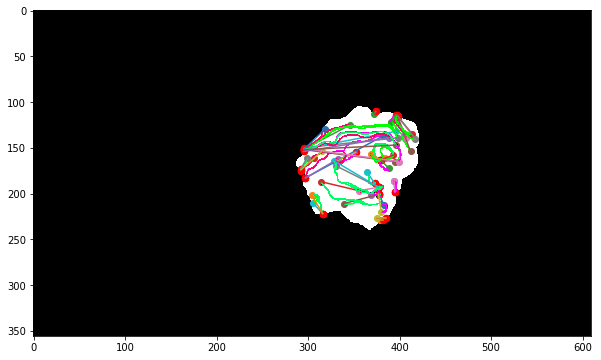

In [51]:
pylab.rcParams['figure.figsize'] = (10, 16)
fig=plt.figure()

colors=["#FF00FF", "#00FF00", "#FF0066", "#00FF66"]

for i in range(len(traj)):
    col = colors[i%len(colors)]
    plot_trajectory(fig, traj[i][:], color=col)
    plot_start_end(fig, traj[i][:])

In [ ]:
pylab.rcParams['figure.figsize'] = (4, 5)
imshow(segimgs[0])

In [41]:
def divergence(F):
    """ compute the divergence of n-D scalar field `F` """
    return reduce(np.add,np.gradient(F))

In [42]:
grad_x=np.gradient(avg_flow_x) 
shape(grad_x)

(2, 595, 403)

In [43]:
grad_y=np.gradient(avg_flow_y) 

In [44]:
div= np.add(grad_x, grad_y)

In [45]:
div

array([[[ -1.68756571e-07,  -4.18583397e-07,  -3.31706872e-07, ...,
          -1.67136150e-07,  -3.44785747e-08,  -1.89491036e-08],
        [ -3.13471560e-07,  -8.21245635e-07,  -1.08364407e-06, ...,
          -4.96278801e-07,  -6.05514288e-08,   1.94552300e-07],
        [ -1.94414883e-06,  -3.69384543e-06,  -1.38482574e-06, ...,
          -7.25912628e-07,   8.68532027e-07,   2.33130640e-06],
        ..., 
        [  4.30328328e-06,   4.08516325e-06,  -2.81030452e-07, ...,
           4.65208177e-05,   1.20851291e-05,   4.83771510e-06],
        [  4.62035132e-07,   8.08203424e-07,   5.70692634e-07, ...,
           3.36097537e-06,   1.51487711e-08,  -5.82129474e-08],
        [  2.88173595e-07,   6.46379192e-07,   8.15370527e-07, ...,
           1.48546383e-06,  -3.39511985e-07,  -3.56764644e-07]],

       [[  1.17707671e-07,   1.70533326e-07,   7.63295645e-07, ...,
           3.47258901e-06,   1.40607824e-07,   4.14744257e-08],
        [ -1.32119169e-07,   8.90581902e-08,   9.39548386e-0

In [50]:
def euclid(a, b):
    
    c = np.zeros((595, 403))
    for i in range(595):
        for j in range(403):
            c[i][j] =  a[i][j]*a[i][j] + b[i][j]*b[i][j]
            c[i][j] = np.sqrt(c[i][j])
    
    
    return c

In [51]:
vec = euclid(avg_flow_x, avg_flow_y)

In [52]:
shape(vec)

(595, 403)

In [53]:
div = -1*  reduce(np.add,np.gradient(vec))

In [86]:
shape(div)

(356, 610)

In [54]:
print np.min(div)
print np.max(div)

-0.672199225268
0.727286503377


In [56]:
flg = numpy.full((595, 403), False, dtype=bool)
for i in range(595):
    for j in range(403):
        if div[i][j] < -.59:
            flg[i][j]= 1
            print ((i,j))
        else:
            flg[i][j]=0
            

            

(362, 172)
(363, 171)
(363, 172)


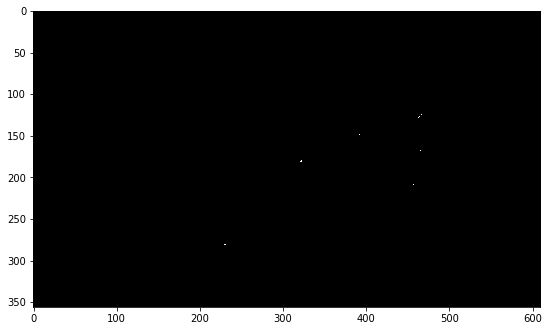

In [105]:
pylab.rcParams['figure.figsize'] = (20, 7)
fig=plt.figure()
ax=fig.add_subplot(1,2,1)
ax.imshow(flg, plt.get_cmap('gray'))

In [ ]:
eps= 0.3
for i in range(356):
    for j in range(610):
        if div[i][j] :